# About
In this notebook I will attempt to simulate matrix multiplication using spatial light modulators (SLM).

## Data Representation
Data is stored as some attribute of light (e.g. amplitude) so we will need some way of representing this in code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LightWave:
    """A 1-dimensional light wave."""
    velocity = 3e8  # speed of light
    
    def __init__(self, amplitude=1, center_amplitude=0, phase=0, frequency=1, period=None,
                wavelength=None):
        """Initialise a light wave.
        
        Arguments:
            amplitude: the maximum amplitude of the wave.
            center_amplitude: offset on the y-axis.
            phase: a real-valued number in the interval [0, 2pi] that 
                   represents the phase of the wave. 
            frequency: the frequency of the wave in Hz. Ignored if period
                       or wavelength is set.
            period: the period of the wave. Ignored if either frequency
                    or wavelength are set.
            wavelength: the wavelength in meters. Ignored if either
                        frequency or period are set.
        """
        self.amplitude = amplitude
        self.phase = phase
        
        if wavelength is not None:
            self.wavelength = wavelength
            self.frequency = LightWave.velocity / wavelength
            self.period = 1 / self.frequency
        elif period is not None:
            self.period = period
            self.frequency = 1 / period
            self.wavelength = LightWave.velocity / self.frequency
        else:
            self.frequency = frequency
            self.period = 1 / frequency
            self.wavelength = LightWave.velocity / frequency
            
        self.angular_frequency = 2 * np.pi * self.frequency
        self.wavenumber = 2 * np.pi / self.wavelength
        
    def copy(self):
        """Create a copy of this wave."""
        return LightWave(self.amplitude, self.phase, self.frequency)
        
    def phase_shift(self, by):
        """Shift the phase of the wave by a given amount.
        
        Arguments:
            by: a multiple of pi representing how much to shift the phase 
                by.
                    
        Returns: a new wave with its phase shifted. Phase is clipped into 
                 the interval [0, 2pi].
        """
        result = self.copy()
        result.phase = np.abs((result.phase + by) % (2 * np.pi))
        
        return result
    
    def modulated_amplitude(self, x=0, t=0):
        """Get the modulated amplitude.
        
        Arguments:
            x: space coordinate.
            t: time coordinate.
        
        Returns: the amplitude of the wave based on its current state.
        """
        return self.amplitude * np.sin(self.wavenumber * x - 
                                       self.angular_frequency * t + 
                                       self.phase)

In [3]:
import unittest

class TestLightWave(unittest.TestCase):
    def get_test_vars(self):
        a = LightWave(frequency=3e8) # 300 MHz
        b = LightWave(period=1/3e8) # 3 1/3 ns
        c = LightWave(wavelength=1) # 1 meter
        
        return a, b, c
    
    def test_computed_frequency(self):
        a, b, c = self.get_test_vars()
        
        self.assertEqual(a.frequency, b.frequency)
        self.assertEqual(b.frequency, c.frequency)

    def test_computed_period(self):
        a, b, c = self.get_test_vars()
        
        self.assertEqual(a.period, b.period)
        self.assertEqual(b.period, c.period)

    def test_computed_wavelength(self):
        a, b, c = self.get_test_vars()
        
        self.assertEqual(a.wavelength, b.wavelength)
        self.assertEqual(b.wavelength, c.wavelength)
        
    def test_phase_shift(self):
        a, _, _ = self.get_test_vars()        
        a.phase = 0        
        
        b = a.phase_shift(by=-np.pi)        
        self.assertEqual(b.phase, np.pi)
        
        b = a.phase_shift(by=np.pi)        
        self.assertEqual(b.phase, np.pi)
        
        b = a.phase_shift(by=-3 * np.pi)
        self.assertEqual(b.phase, np.pi)
        
        b = a.phase_shift(by=3 * np.pi)
        self.assertEqual(b.phase, np.pi)
            
unittest.main(argv=['first-arg-is-ignored'], exit=False)

...F
FAIL: test_phase_shift (__main__.TestLightWave)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-3-73027b088cd5>", line 34, in test_phase_shift
    self.assertEqual(b.phase, np.pi)
AssertionError: 2.68649273379863 != 3.141592653589793

----------------------------------------------------------------------
Ran 4 tests in 0.005s

FAILED (failures=1)


Text(0, 0.5, 'Amplitude')

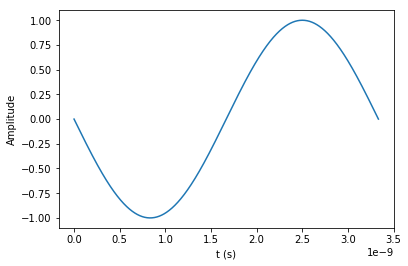

In [4]:
a = LightWave(frequency=3e8) # 300 MHz

T = np.linspace(0, 1/3e8, 1001)
plt.plot(T, [a.modulated_amplitude(t=t) for t in T])
plt.xlabel('t (s)')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

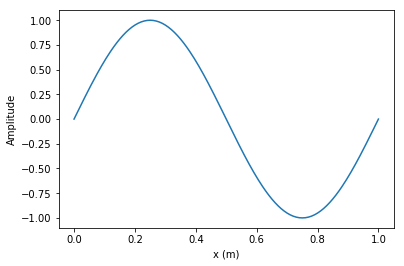

In [5]:
T = np.linspace(0, 1, 201)
plt.plot(T, [a.modulated_amplitude(x=t) for t in T])
plt.xlabel('x (m)')
plt.ylabel('Amplitude')

## Matrix Encoding
There are multiple possible ways of encoding a matrix as light. Some methods that come to mind are:
1. normalising the input space to [0, 1] then scale so that the new range of values lies in the interval $[0, 2\pi]$ in the case of phase modulation, or scale and shift to the interval $[-minifloat.max, minifloat.max]$ in the case of amplitude modulation.
2. squishing the input with a tanh activation function and scaling by $\frac{minifloat.max}{2}$ for amplitude modulation
3. squishing the input with a sigmoid activation function and scaling by $2\pi$ for phase modulation
4. standardising the data such that X~N(0, 1) for amplitude modulation
5. similar to above except X~N($\pi$, $\frac{\pi}{3}$)

### Normalisation

In [ ]:
class Normaliser

### Basic Encoding/Decoding

In [6]:
import pandas as pd

x = np.random.normal(0, 1, (128, 128))
w = np.random.normal(0, 1, (128, 128))

In [7]:
def encode(x):
    assert len(x.shape) == 2
    
    y = []
    m, n = x.shape
    red_laser_wavelength = 6.71e-7
    
    for row in range(m):
        y.append([])
        
        for col in range(n):
            cell_value = LightWave(amplitude=x[row, col], wavelength=red_laser_wavelength)
            y[row].append(cell_value)
            
    return y
            

In [8]:
x_light = encode(x)

Text(0, 0.5, 'Amplitude')

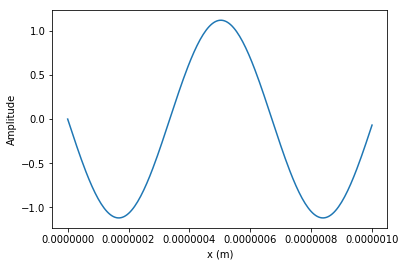

In [9]:
dist = np.linspace(0, 1e-6, 201)
plt.plot(dist, [x_light[0][0].modulated_amplitude(x=x) for x in dist])
plt.xlabel('x (m)')
plt.ylabel('Amplitude')

In [10]:
def decode(x):
    x = np.array(x)
    assert len(x.shape) == 2
    
    y = []
    m, n = x.shape
    
    for row in range(m):
        y.append([])
        
        for col in range(n):
            cell_value = x[row, col].amplitude
            y[row].append(cell_value)
            
    return y

In [11]:
assert np.array_equal(decode(x_light), x)

In [18]:
class Coder:
    def __init__(self, strategy: Strategy):
        self.strategy = strategy
        
    def encode(self, a: np.array):
        assert len(a.shape) == 2
    
        encoded = []
        m, n = a.shape

        for row in range(m):
            encoded.append([])

            for col in range(n):
                cell_value = self.strategy.encode(a[row, col])
                encoded[row].append(cell_value)

        return np.array(encoded)
        
    def decode(self, a: np.array):
        assert len(a.shape) == 2
    
        decoded = []
        m, n = a.shape

        for row in range(m):
            decoded.append([])

            for col in range(n):
                cell_value = self.strategy.decode(a[row, col])
                decoded[row].append(cell_value)

        return np.array(decoded)
    
    
class Strategy: 
    def __init__(self, wavelength=6.71e-7):
        """constructor.
        
        Arguments:
            wavelength: the wavelength of the light wave. Defaults to the wavelength of a generic red laser.
        """
        self.wavelength = wavelength
        
    def encode(self, x):
        return x
    
    def decode(self, x):
        return x
    
class AmplitudeEncoding(Strategy):    
    def encode(self, x):
        return LightWave(amplitude=x, wavelength=self.wavelength)
    
    def decode(self, x):
        return x.amplitude
    
class PhaseEncoding(Strategy):
    def encode(self, x):
        return LightWave(phase=x, wavelength=self.wavelength)
    
    def decode(self, x):
        return x.phase

In [16]:
coder = Coder(strategy=AmplitudeEncoding())

assert np.array_equal(coder.decode(coder.encode(x)), x)

In [19]:
coder = Coder(strategy=PhaseEncoding())

assert np.array_equal(coder.decode(coder.encode(x)), x)